# MavenToy E-Commerce Data Analysis

This notebook explores key business metrics using curated Gold views
from a SQL Server data warehouse.

0. [Loading Data](#Loading-Data)
1. [Business Overview](#Business-Overview)
   - [Net Revenue vs Net Profit](#Net-Revenue-vs-Net-Profit)
   - [Orders Trend](#Orders-Trend)
2. [Revenue Quality](#Revenue-Quality)
   - [Refund Impact](#Refund-Impact)
3. [Product Decisions](#Product-Decisions)
   - [Top Products by Profit](#Top-Products-by-Profit)
   - [Profit vs Returns](#Profit-vs-Returns)
4. [Marketing Performance](#Marketing-Performance)
   - [Conversion Rate by Channel](#Conversion-Rate-by-Channel)


In [1]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Loading Data

In [2]:
# Establish connection
cnxn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    f"SERVER={r'localhost\SQLEXPRESS'};"
    f"DATABASE={'ecommerceDWH'};"
    "Trusted_Connection=yes;")

In [3]:
# Read data into DataFrame
df_pyodbc = pd.read_sql_query("SELECT TOP 10 * FROM silver.maven_orders", cnxn)
df_pyodbc.head()

,order_id,created_at,website_session_id,user_id,primary_product_id,items_purchased,price_usd,cogs_usd
0,1,2012-03-19 10:42:46,20,20,1,1,49.99,19.49
1,2,2012-03-19 19:27:37,104,104,1,1,49.99,19.49
2,3,2012-03-20 06:44:45,147,147,1,1,49.99,19.49
3,4,2012-03-20 09:41:45,160,160,1,1,49.99,19.49
4,5,2012-03-20 11:28:15,177,177,1,1,49.99,19.49


In [4]:
gold_views = pd.read_sql_query("""
SELECT TABLE_NAME
FROM INFORMATION_SCHEMA.VIEWS
WHERE TABLE_SCHEMA = 'gold'
ORDER BY TABLE_NAME
""", cnxn)

gold_views

,TABLE_NAME
0,maven_daily_orders_revenue
1,maven_marketing_funnel
2,maven_products_performance


In [5]:
daily_revenue = pd.read_sql_query(f"SELECT * FROM gold.maven_daily_orders_revenue", cnxn) 
daily_revenue.head()

,order_date,refunds_count,total_orders,revenue_usd,gross_profit_usd,refunded_usd,net_revenue_usd,net_profit_usd,cumulative_net_revenue,cumulative_net_profit,rank_by_revenue,rank_by_revenue_ties
0,2014-11-28,3,417,27404.23,17282.5,141.97,27262.26,17140.53,1383771.24,839984.38,1,1
1,2014-12-01,6,339,22323.31,14110.5,295.94,22027.37,13814.56,1408644.01,855455.02,2,2
2,2013-11-29,0,218,11707.74,7180.0,0.00,11707.74,7180.00,440324.15,260561.63,3,3
3,2013-12-02,1,160,8538.35,5235.5,49.99,8488.36,5185.51,449522.37,266142.16,4,4
4,2015-02-10,5,119,7562.51,4823.5,237.95,7324.56,4585.55,1698795.91,1035244.50,5,5


In [6]:
products_performance = pd.read_sql_query(f"SELECT * FROM gold.maven_products_performance", cnxn) 
products_performance.head()

,product_id,product_name,items_sold,orders_count,revenue_usd,cogs_usd,gross_profit_kusd,items_returned,return_percentage,rank_by_items_sold,rank_by_revenue,revenue_quintile
0,1,The Original Mr. Fuzzy\r,24226,24226,1211057.74,472164.74,738.89,1237,5.11,1,1,1
1,2,The Forever Love Bear\r,5796,5796,347702.04,130352.04,217.35,129,2.23,2,2,2
2,3,The Birthday Sugar Panda\r,4985,4985,229260.15,72232.65,157.03,301,6.04,4,3,3
3,4,The Hudson River Mini Bear\r,5018,5018,150489.82,47620.82,102.87,64,1.28,3,4,4


In [7]:
marketing_funnel = pd.read_sql_query(f"SELECT * FROM gold.maven_marketing_funnel", cnxn) 
marketing_funnel.head()

,utm_source,sessions,orders,conversion_rate_percentage,cumulative_sessions,cumulative_orders,rank_per_source
0,bsearch,62823,4519,7.19,62823,4519,1
1,gsearch,316035,21333,6.75,316035,21333,1
2,NULL,83328,6118,7.34,83328,6118,1
3,socialbook,10685,343,3.21,10685,343,1


## Business Overview

### Net Revenue vs Net Profit

In [9]:
daily_revenue['order_date'] = pd.to_datetime(daily_revenue['order_date'])
daily_revenue = daily_revenue.sort_values('order_date')

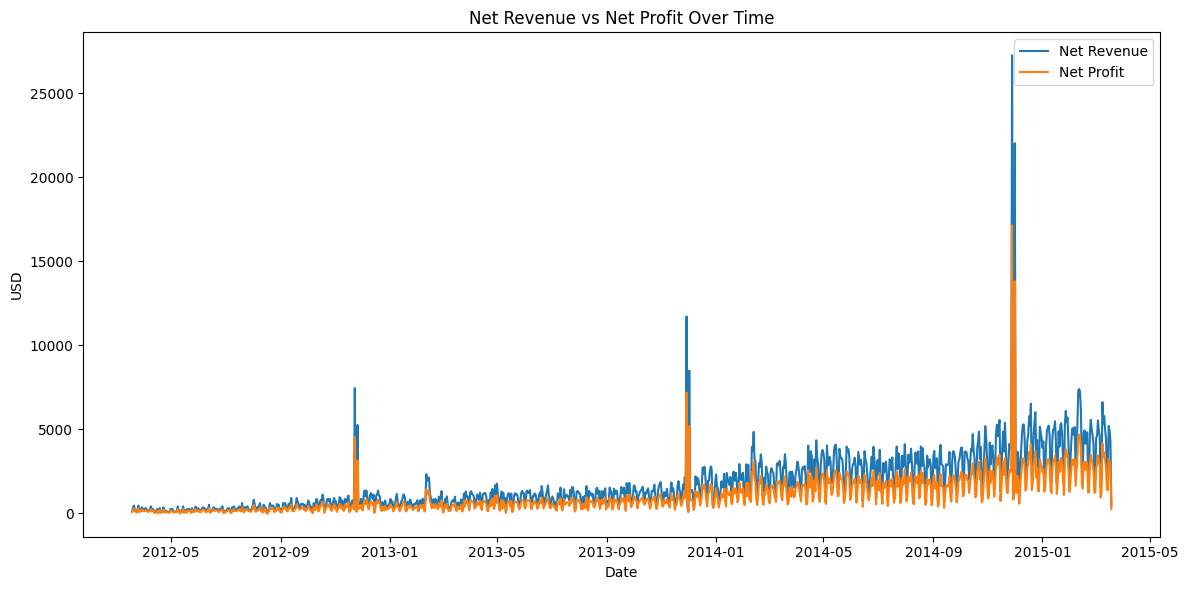

In [10]:
plt.figure(figsize=(12,6))

plt.plot(
    daily_revenue['order_date'],
    daily_revenue['net_revenue_usd'],
    label='Net Revenue'
)

plt.plot(
    daily_revenue['order_date'],
    daily_revenue['net_profit_usd'],
    label='Net Profit'
)

plt.title('Net Revenue vs Net Profit Over Time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.tight_layout()
plt.show()


### Orders Trend

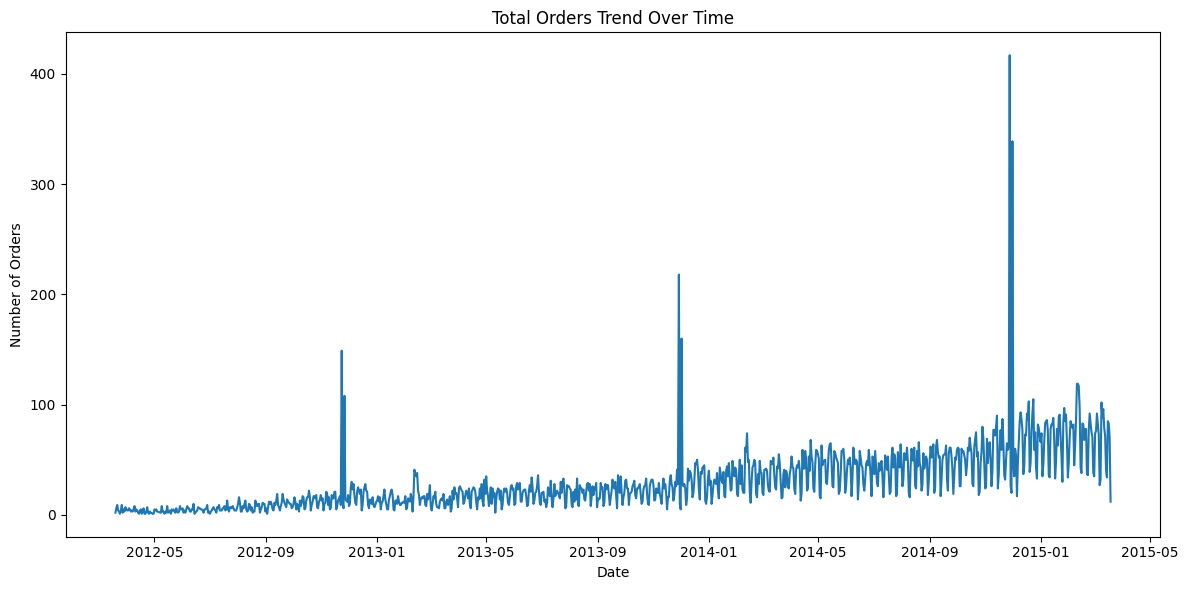

In [11]:
plt.figure(figsize=(12,6))

plt.plot(
    daily_revenue['order_date'],
    daily_revenue['total_orders']
)

plt.title('Total Orders Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


## Revenue Quality

### Refund Impact

In [13]:
daily_revenue["refund_rate"] = (
    daily_revenue["refunds_count"] / daily_revenue["total_orders"]
)

daily_revenue["refund_impact_pct"] = (
    daily_revenue["refunded_usd"] / daily_revenue["revenue_usd"]
)

daily_revenue[["order_date", "refund_rate", "refund_impact_pct"]].tail()

,order_date,refund_rate,refund_impact_pct
312,2015-03-15,0.088235,0.060272
33,2015-03-16,0.023529,0.018897
39,2015-03-17,0.072289,0.052267
85,2015-03-18,0.028571,0.022161
779,2015-03-19,0.250000,0.254911


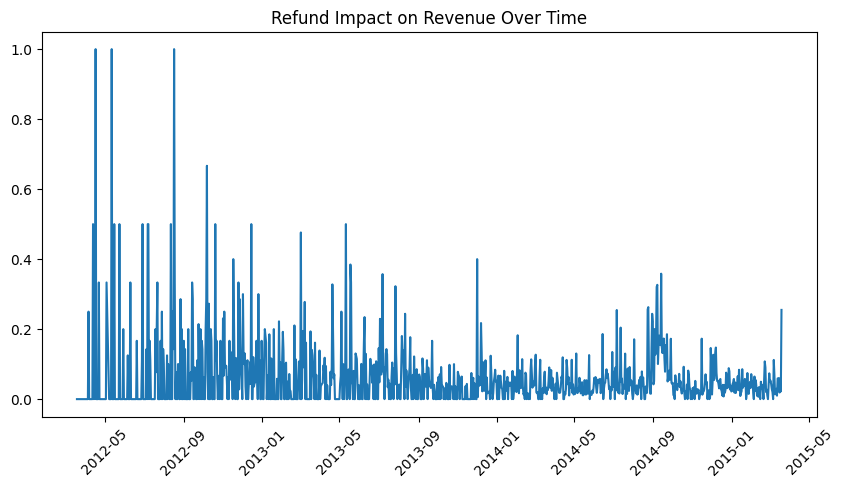

In [14]:
plt.figure(figsize=(10,5))
plt.plot(daily_revenue["order_date"], daily_revenue["refund_impact_pct"])
plt.title("Refund Impact on Revenue Over Time")
plt.xticks(rotation=45)
plt.show()


## Product Decisions

### Top Products by Profit

In [16]:
top_products = (
    products_performance
    .sort_values("gross_profit_kusd", ascending=False)
    .head(10))

top_products

,product_id,product_name,items_sold,orders_count,revenue_usd,cogs_usd,gross_profit_kusd,items_returned,return_percentage,rank_by_items_sold,rank_by_revenue,revenue_quintile
0,1,The Original Mr. Fuzzy\r,24226,24226,1211057.74,472164.74,738.89,1237,5.11,1,1,1
1,2,The Forever Love Bear\r,5796,5796,347702.04,130352.04,217.35,129,2.23,2,2,2
2,3,The Birthday Sugar Panda\r,4985,4985,229260.15,72232.65,157.03,301,6.04,4,3,3
3,4,The Hudson River Mini Bear\r,5018,5018,150489.82,47620.82,102.87,64,1.28,3,4,4


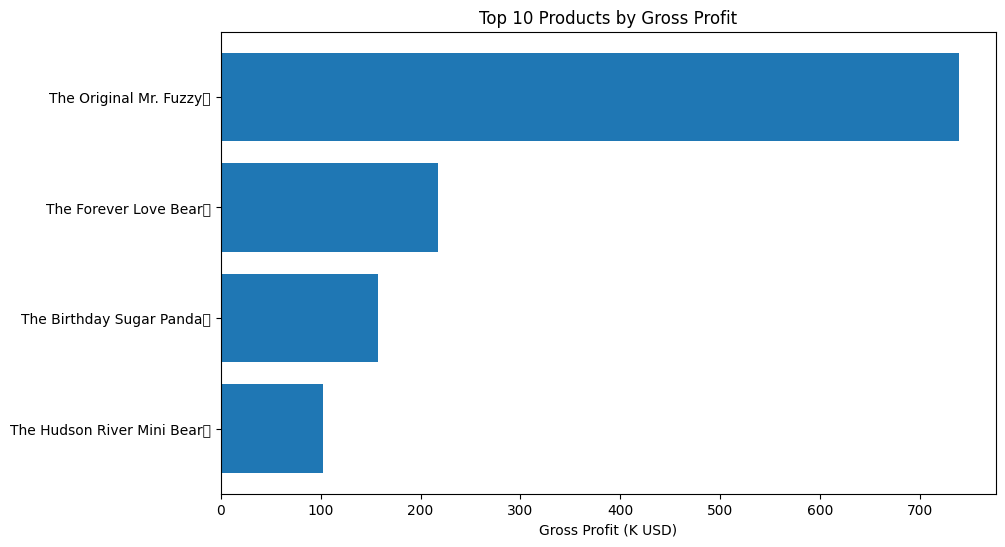

In [17]:
plt.figure(figsize=(10,6))

plt.barh(
    top_products["product_name"],
    top_products["gross_profit_kusd"])

plt.xlabel("Gross Profit (K USD)")
plt.title("Top 10 Products by Gross Profit")

plt.gca().invert_yaxis()
plt.show()

### Profit vs Returns

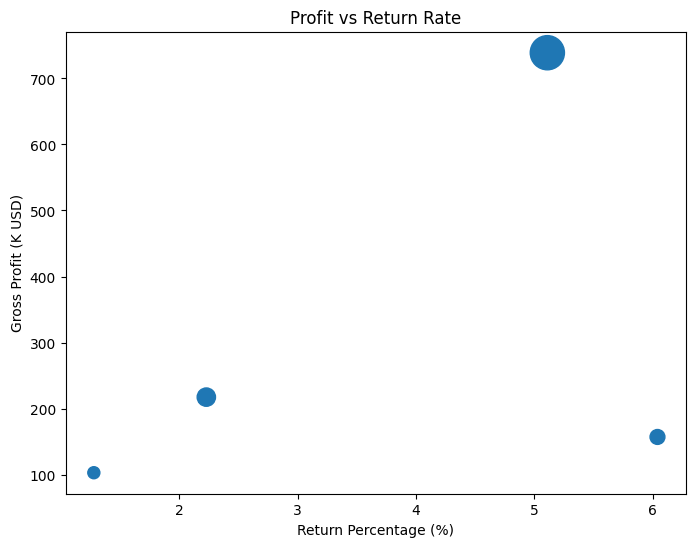

In [19]:
plt.figure(figsize=(8,6))

plt.scatter(
    products_performance["return_percentage"],
    products_performance["gross_profit_kusd"],
    s=products_performance["revenue_usd"] / 2000 
)

plt.xlabel("Return Percentage (%)")
plt.ylabel("Gross Profit (K USD)")
plt.title("Profit vs Return Rate")

plt.show()


## Marketing Performance

### Conversion Rate by Channel

In [21]:
marketing_funnel["conversion_rate"] = (
    marketing_funnel["orders"] / marketing_funnel["sessions"] * 100)

marketing_funnel

,utm_source,sessions,orders,conversion_rate_percentage,cumulative_sessions,cumulative_orders,rank_per_source,conversion_rate
0,bsearch,62823,4519,7.19,62823,4519,1,7.193225
1,gsearch,316035,21333,6.75,316035,21333,1,6.750202
2,NULL,83328,6118,7.34,83328,6118,1,7.342070
3,socialbook,10685,343,3.21,10685,343,1,3.210108


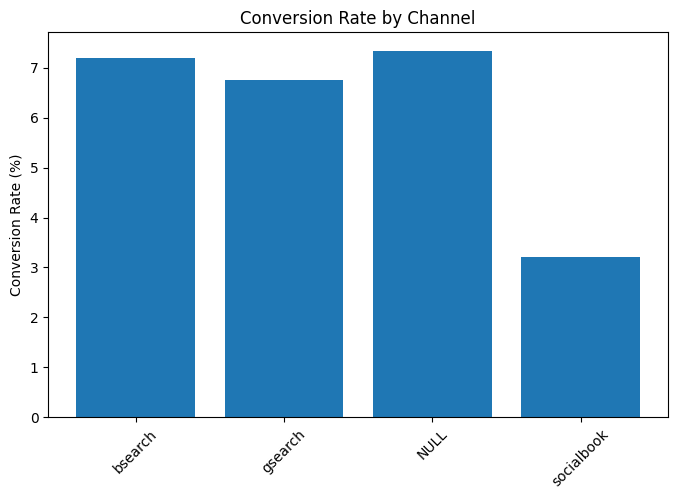

In [23]:
plt.figure(figsize=(8,5))

plt.bar(
    marketing_funnel["utm_source"],
    marketing_funnel["conversion_rate"]
)

plt.ylabel("Conversion Rate (%)")
plt.title("Conversion Rate by Channel")

plt.xticks(rotation=45)

plt.show()